# Retail Sales Forecasting sem exógena

Dados de vendas no varejo para prever resultados com histórico limitado, eventos sazonais e promoções. Os dados cobrem 45 lojas, com promoções antes de feriados importantes. Semanas com esses feriados têm peso extra, e o desafio é prever o impacto nos departamentos.

Link da base no kaggle: https://www.kaggle.com/datasets/manjeetsingh/retaildataset?select=sales+data-set.csv


__Documentação dos dados:__

Store: Número identificador da loja (tipo inteiro). <br>
Dept: Número identificador do departamento (tipo inteiro). <br>
Date: Data de registro das vendas (tipo texto, object). <br>
Weekly_Sales: Valor das vendas semanais (tipo float). <br>
IsHoliday: Indicador de feriado (tipo bool). <br>


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
# Carregando os dados
data = pd.read_csv("sales_dataset.csv", parse_dates=["Date"])
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index("Date", inplace=True)


In [62]:
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [63]:
data.info

<bound method DataFrame.info of             Store  Dept  Weekly_Sales  IsHoliday
Date                                            
2010-02-05      1     1      24924.50      False
2010-02-12      1     1      46039.49       True
2010-02-19      1     1      41595.55      False
2010-02-26      1     1      19403.54      False
2010-03-05      1     1      21827.90      False
...           ...   ...           ...        ...
2012-09-28     45    98        508.37      False
2012-10-05     45    98        628.10      False
2012-10-12     45    98       1061.02      False
2012-10-19     45    98        760.01      False
2012-10-26     45    98       1076.80      False

[421570 rows x 4 columns]>

In [71]:
# Verificando valores negativos na coluna 'Weekly_Sales'
negative_values = (data['Weekly_Sales'] < 0).sum()

# Exibindo o resultado
if negative_values > 0:
    print(f"Há {negative_values} valores negativos na coluna 'Weekly_Sales'.")
else:
    print("Não há valores negativos na coluna 'Weekly_Sales'.")


Há 1285 valores negativos na coluna 'Weekly_Sales'.


In [72]:
# Removendo valores negativos na coluna 'Weekly_Sales'
data = data[data['Weekly_Sales'] >= 0]

In [73]:
# Verificar valores negativos na coluna 'Weekly_Sales'
negative_values = (data['Weekly_Sales'] < 0).sum()

# Exibir o resultado
if negative_values > 0:
    print(f"Há {negative_values} valores negativos na coluna 'Weekly_Sales'.")
else:
    print("Não há valores negativos na coluna 'Weekly_Sales'.")

Não há valores negativos na coluna 'Weekly_Sales'.


In [74]:
# Removendo valores negativos na coluna 'Weekly_Sales'
data = data[data['Weekly_Sales'] >= 0]

In [75]:
# Filtrando para uma única loja e departamento (exemplo: Store 1, Dept 1)
store_dept_data = data[(data['Store'] == 1) & (data['Dept'] == 1)]

In [76]:
# Selecionando a série temporal de vendas semanais e a coluna `IsHoliday`
sales_data = store_dept_data['Weekly_Sales']
is_holiday_data = store_dept_data['IsHoliday']

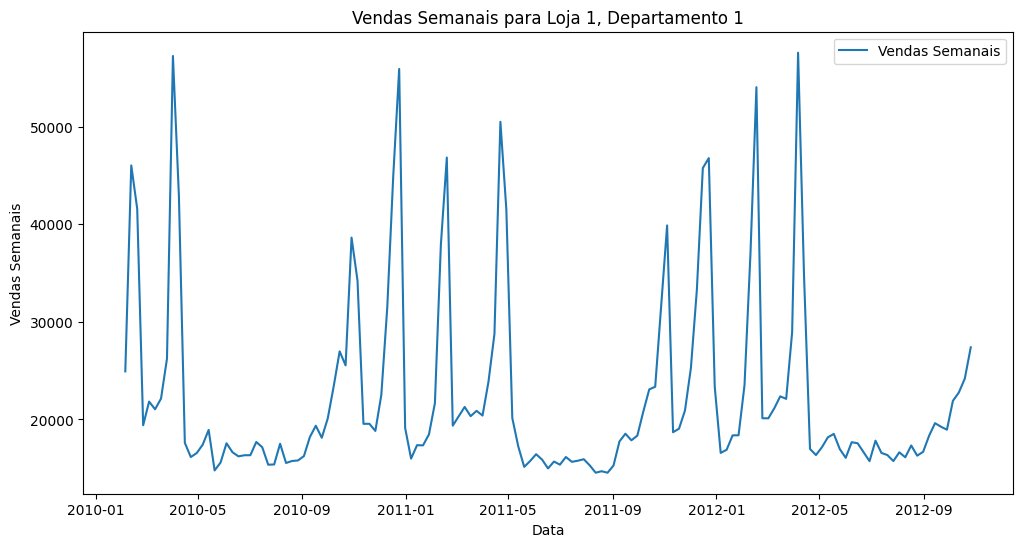

In [77]:
# Visualizar a série temporal
plt.figure(figsize=(12, 6))
plt.plot(sales_data, label="Vendas Semanais")
plt.xlabel("Data")
plt.ylabel("Vendas Semanais")
plt.title("Vendas Semanais para Loja 1, Departamento 1")
plt.legend()
plt.show()

# Aplicando o teste

In [78]:
# Dividindo os dados em treino e teste
train_size = int(len(sales_data) * 0.8)
train, test = sales_data[:train_size], sales_data[train_size:]
train_exog, test_exog = is_holiday_data[:train_size], is_holiday_data[train_size:]


In [79]:
# Configurar o modelo SARIMA com sazonalidade semanal
# model = SARIMAX(train, order=(2, 0, 1), seasonal_order=(1, 1, 1, 20))
# model_fit = model.fit(disp=False)

# esse deu
# model = SARIMAX(train, order=(3, 0, 1), seasonal_order=(1, 1, 1 ,52))

model = SARIMAX(train, order=(3, 0, 1), seasonal_order=(1, 1, 1 ,52))
model_fit = model.fit(disp=False)

# Fazer previsões para o período de teste
forecast = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE: 7434.95


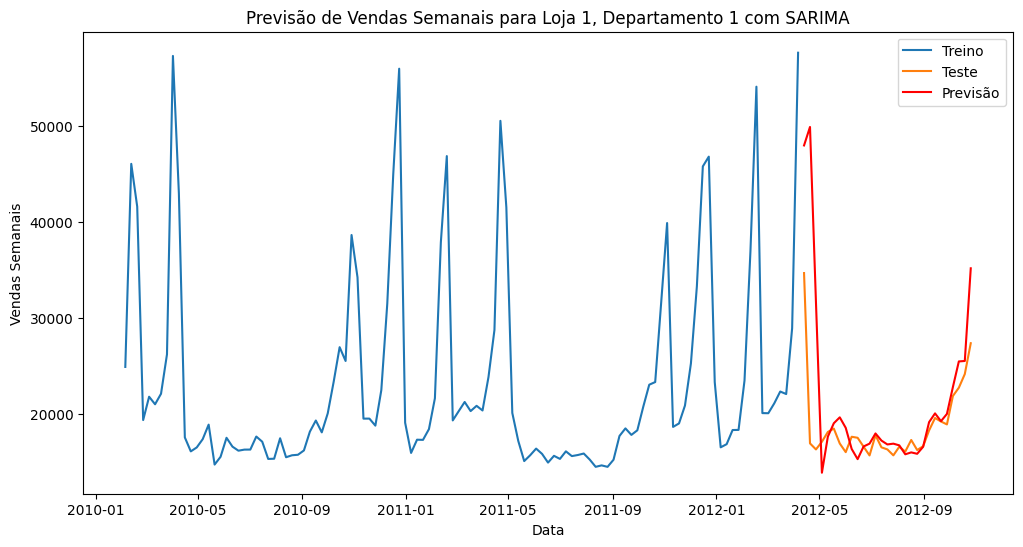

In [80]:
# Avaliar o modelo com RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'RMSE: {rmse:.2f}')

# Visualizar o resultado
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Treino")
plt.plot(test.index, test, label="Teste")
plt.plot(test.index, forecast, color="red", label="Previsão")
plt.xlabel("Data")
plt.ylabel("Vendas Semanais")
plt.title("Previsão de Vendas Semanais para Loja 1, Departamento 1 com SARIMA")
plt.legend()
plt.show()


In [81]:
import numpy as np
from sklearn.metrics import mean_squared_error
mape = np.mean(np.abs((test - forecast) / test)) * 100
accuracy = 100 - mape

print("Map: ", mape)
print("Acurácia: ", accuracy)

Map:  17.313770200041372
Acurácia:  82.68622979995862
